In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

Set seeds

In [11]:
import random

seed_value = 52
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)


## Prepare Data 


Additionally, visualize the data

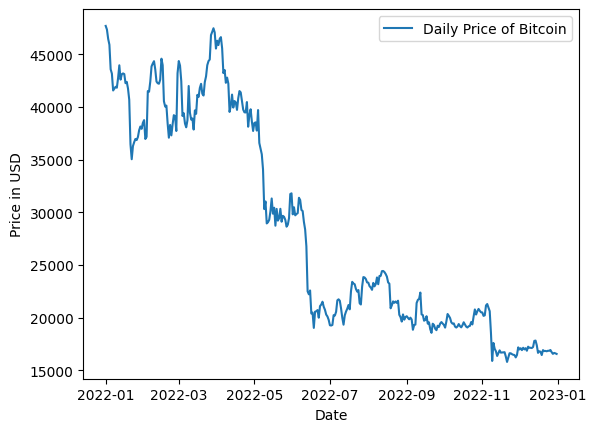

In [12]:
#Load in data
df = pd.read_csv(r"C:\Users\Chris\OneDrive\Documents\LSTM v ARIMA research\Predicting-Bitcoin-Returns-with-Long-Short-Term-Memory-LSTM-Neural-Networks\BTC-USD.csv")

prices = df["Close"].values

dates = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
ts = pd.Series(prices, index=dates)

plt.plot(ts)
plt.legend(['Daily Price of Bitcoin'])
plt.xlabel("Date")
plt.ylabel("Price in USD")
plt.show()

Plotting the ACF may give some direction in setting look back size for the neural network

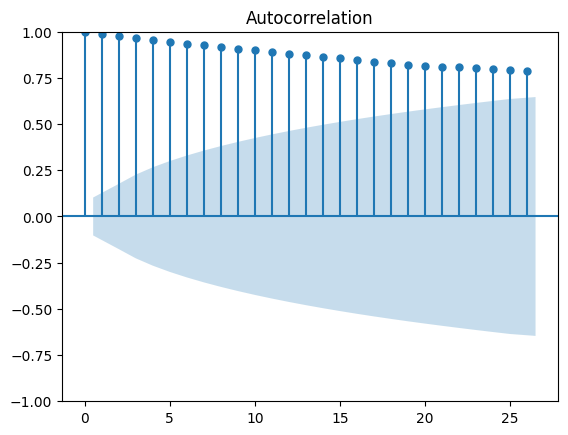

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(prices)
plt.show()

### Create log returns of bitcoin price

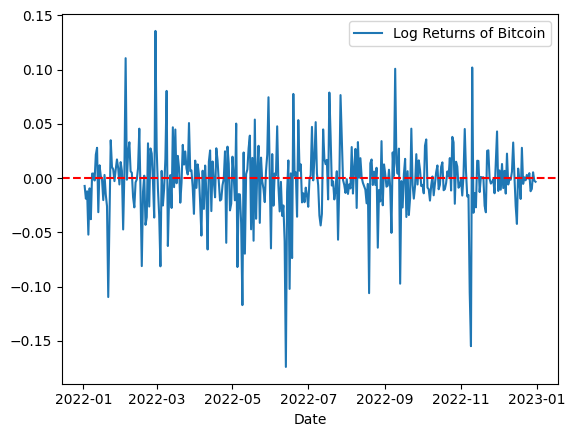

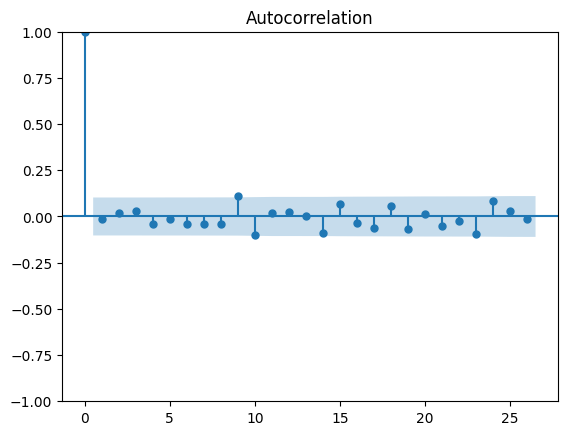

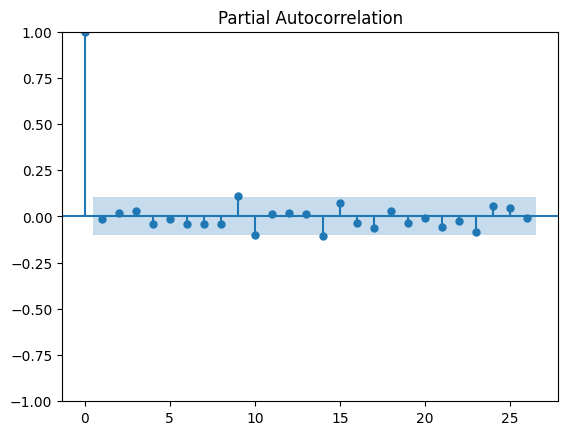

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf

log_P = np.log(prices)

#1st difference of ts to remove trend and seasonality
diff = np.diff(log_P)
diff = diff.astype('float32')

dates_4_diff = pd.date_range(start='2022-01-02', end='2022-12-31', freq='D')
timeseries_indexed = pd.Series(diff, index=dates_4_diff)

plt.plot(timeseries_indexed)
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(["Log Returns of Bitcoin"])
plt.xlabel("Date")
plt.show()

plot_acf(diff)
plt.show()

plot_pacf(diff)
plt.show()

diff.resize((364,1)) #necessary to make sure the code works


### Use ADF Test to check for stationarity


In [15]:
from statsmodels.tsa.stattools import adfuller

unit_test = adfuller(diff)

#Print results
print('ADF Statistic: %f' % unit_test[0])
print('p-value: %f' % unit_test[1])
print('Critical Values:', unit_test[4])

if unit_test[1] <= 0.05:
    print(f'Reject the null hypothesis. The time-series is stationary.')
else: 
    print(f"Fail to reject the null hypothesis. The time-series is non-stationary")


ADF Statistic: -19.230854
p-value: 0.000000
Critical Values: {'1%': -3.448493650810824, '5%': -2.8695352280356556, '10%': -2.5710293341377715}
Reject the null hypothesis. The time-series is stationary.


### Train-Validation-Test Split

In [16]:
# train-test split for time series
train_size = int(len(diff) * 0.60)
train, rest = diff[:train_size], diff[train_size:]
validation_size = int(len(rest) * 0.50)
validation, test = rest[:validation_size], rest[validation_size:]

print(len(train))
print(len(validation))
print(len(test))

218
73
73


### Create tensor dataset

In [17]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        inputs = dataset[i:i+lookback]
        labels = dataset[i+lookback:i+lookback+1]
        X.append(inputs)
        y.append(labels)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

lookback = 10
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
X_valid, y_valid = create_dataset(validation, lookback=lookback)

## LSTM Class


In [21]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=60, num_layers=1, batch_first=True)
        self.linear = nn.Linear(60, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x

## Training


In [22]:
model = LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=1)

n_epochs = 1400
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        y_pred = y_pred.unsqueeze(2)
        loss = torch.sqrt(loss_fn(y_pred, y_batch)) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        y_pred = y_pred.unsqueeze(2)
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
        
        y_pred = model(X_valid)
        y_pred = y_pred.unsqueeze(2)
        test_rmse = torch.sqrt(loss_fn(y_pred, y_valid))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
 

Epoch 0: train RMSE 0.0379, test RMSE 0.0303
Epoch 100: train RMSE 0.0367, test RMSE 0.0301
Epoch 200: train RMSE 0.0357, test RMSE 0.0336
Epoch 300: train RMSE 0.0334, test RMSE 0.0359
Epoch 400: train RMSE 0.0318, test RMSE 0.0385
Epoch 500: train RMSE 0.0303, test RMSE 0.0351
Epoch 600: train RMSE 0.0285, test RMSE 0.0389
Epoch 700: train RMSE 0.0240, test RMSE 0.0415
Epoch 800: train RMSE 0.0165, test RMSE 0.0411
Epoch 900: train RMSE 0.0140, test RMSE 0.0429
Epoch 1000: train RMSE 0.0123, test RMSE 0.0407
Epoch 1100: train RMSE 0.0082, test RMSE 0.0438
Epoch 1200: train RMSE 0.0060, test RMSE 0.0408
Epoch 1300: train RMSE 0.0048, test RMSE 0.0418


In [30]:
print(len(y_valid))

63


## Plotting Results of LSTM




tensor(0.0056)
tensor(0.0433)


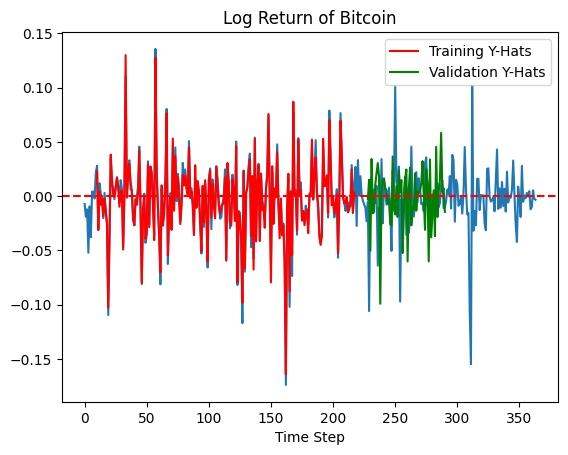

In [35]:
with torch.no_grad():
    ##Shift train predictions for plotting
    train_plot = np.ones_like(diff) * np.nan
    #get predictions for training set
    y_hat_train = model(X_train)
    #RMSE for training set
    rmse_train = torch.sqrt(loss_fn(y_hat_train.unsqueeze(2), y_train))
    #Plot the training predictions
    train_plot[lookback:train_size] = y_hat_train


    #Shift validation predictions for plotting
    valid_plot = np.ones_like(diff) * np.nan
    #Get predictions for testing set
    y_hat_valid = model(X_valid)
    #RMSE for testing set
    rmse_valid = torch.sqrt(loss_fn(y_hat_valid.unsqueeze(2), y_valid))
    #Plot the testing predictions
    valid_plot[train_size+lookback:train_size+len(y_valid)+lookback] = y_hat_valid

print()
print(rmse_train)
print(rmse_test)


# plot
plt.plot(diff)
plt.plot(train_plot, c='r', label="Training Y-Hats")
plt.plot(valid_plot, c='g', label='Validation Y-Hats')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
plt.axhline(y=0, color='r', linestyle='--')
plt.savefig("365 forecast")
plt.show()

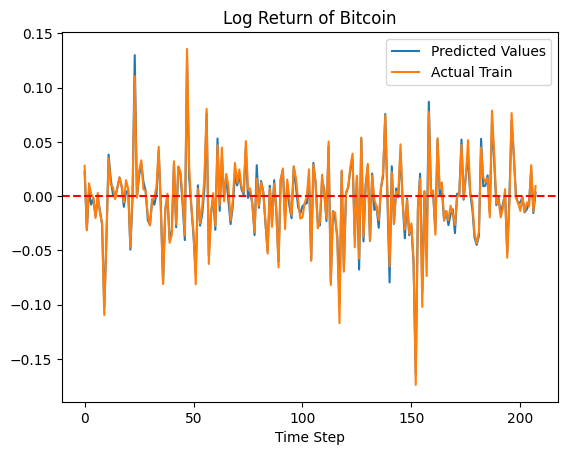

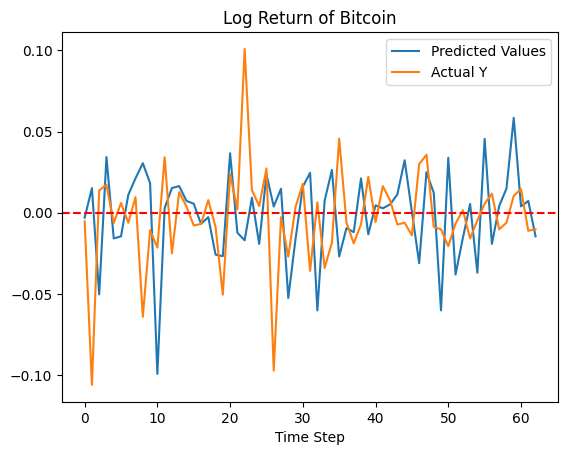

In [36]:
plt.plot(y_hat_train, label="Predicted Values")
plt.plot(y_train.squeeze(), label="Actual Train")
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
plt.savefig("Trained.png")
plt.show()


plt.plot(y_hat_valid, label="Predicted Values")
plt.plot(y_valid.squeeze(), label="Actual Y")
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
plt.savefig("Test.png")
plt.show()